In [1]:
import sys
sys.path.insert(0,'..')

In [3]:
#from food.psql import *
from mytools.tools import get_logger
# logger = get_logger(engine,'bot_logs','food')
# logger.debug({'msg':'starting bot'})
from aiogram import Bot, Dispatcher, executor, types
from aiogram.types import ContentType
from aiogram.dispatcher.filters.state import State, StatesGroup
from aiogram.types.message import ContentTypes
from aiogram.dispatcher import FSMContext
from aiogram.contrib.fsm_storage.memory import MemoryStorage
from sqlalchemy import update
from aiogram.dispatcher.filters.state import State, StatesGroup
from aiogram.utils.callback_data import CallbackData
import typing
import numpy as np
import io


from food.paths import *


API_TOKEN = bot_token

from food.paths import *
from food.search import *
import pandas as  pd
import pytz
timezones = pytz.all_timezones
import requests
from requests.structures import CaseInsensitiveDict
import urllib
from tzwhere import tzwhere

import nest_asyncio
nest_asyncio.apply()

def image2file_obj(img):
    o = io.BytesIO()
    img.save(o, format=i.format)
    return o.getvalue()

async def async_image2file_obj(img):
    return image2file_obj(img)



async def async_search(url):
    return search(url)



bot = Bot(token=API_TOKEN)
storage = MemoryStorage()
dp = Dispatcher(bot, storage=storage)



@dp.message_handler(content_types=ContentType.PHOTO,state='*')
async def process_photo(message: types.Message, state: FSMContext):
    await message.reply('yes')
    global m 
    global i
    m = message


    photo  = message['photo'][-1]
    await photo.download(reference_images_path/photo['file_id'])
    # image_url    = await photo.get_url()
    image_url      = f'https://dima.grankin.eu/reference_images/{photo["file_id"]}'
    
    img,clip_df,masks,urls = async_search(image_url)
    
    i = img
    
    print('started')
    
    img_o = await async_image2file_obj(img)
   
    await message.reply_photo(img_o)
    await message.reply(' '.join(df['description'].tolist()))
    await message.reply(mask[mask!=0].mean())
    
    print('finished')

if __name__ == '__main__': executor.start_polling(dp)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/a

In [10]:
photo  = m['photo'][-1]
await photo.download(reference_images_path/photo['file_id'])
# image_url    = await photo.get_url()
image_url      = f'https://dima.grankin.eu/reference_images/{photo["file_id"]}'

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


In [14]:
image_url

'https://dima.grankin.eu/reference_images/AgACAgIAAxkBAAIKAmLhn0SdD55hleSPR5q57eb-6Lb2AAIZvzEb6jQQS7YEy1gu7EwnAQADAgADeQADKQQ'

In [12]:
img,clip_df,masks,urls = search(image_url)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (1280,1279,3) (1280,1280,3) 

In [13]:
expand_boundaries

NameError: name 'expand_boundaries' is not defined

In [ ]:
img_o = await async_image2file_obj(i)

In [8]:
await m.reply_photo(img_o)

<Message {"message_id": 2478, "from": {"id": 5091011572, "is_bot": true, "first_name": "calorie_bot", "username": "food_classifier_bot"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658772535, "reply_to_message": {"message_id": 2476, "from": {"id": 78882798, "is_bot": false, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "language_code": "en"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658772488, "photo": [{"file_id": "AgACAgIAAxkBAAIJrGLe3Ahpju7CG2OfAjf0NNzEkNMCAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADcwADKQQ", "file_unique_id": "AQADQr0xG0MV8Up4", "file_size": 1212, "width": 90, "height": 51}, {"file_id": "AgACAgIAAxkBAAIJrGLe3Ahpju7CG2OfAjf0NNzEkNMCAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADbQADKQQ", "file_unique_id": "AQADQr0xG0MV8Upy", "file_size": 16703, "width": 320, "height": 180}, {"file_id"

In [5]:
i

NameError: name 'i' is not defined

In [87]:
await m.reply_photo(image2file_obj(i))

<Message {"message_id": 2446, "from": {"id": 5091011572, "is_bot": true, "first_name": "calorie_bot", "username": "food_classifier_bot"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658770476, "reply_to_message": {"message_id": 2445, "from": {"id": 78882798, "is_bot": false, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "language_code": "en"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658770438, "photo": [{"file_id": "AgACAgIAAxkBAAIJjWLe1AYnqWxItAqPc6Oab3GKfY-pAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADcwADKQQ", "file_unique_id": "AQADQr0xG0MV8Up4", "file_size": 1212, "width": 90, "height": 51}, {"file_id": "AgACAgIAAxkBAAIJjWLe1AYnqWxItAqPc6Oab3GKfY-pAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADbQADKQQ", "file_unique_id": "AQADQr0xG0MV8Upy", "file_size": 16703, "width": 320, "height": 180}, {"file_id"

Cause exception while getting updates.
Traceback (most recent call last):
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/bot/api.py", line 139, in make_request
    async with session.post(url, data=req, **kwargs) as response:
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 1138, in __aenter__
    self._resp = await self._coro
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 559, in _request
    await resp.start(conn)
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client_reqrep.py", line 898, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/streams.py", line 616, in read
    await self._waiter
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/asyncio/futures.py", line 284, in __await__
    yield self  # This tells Task to wait for completion.
  File

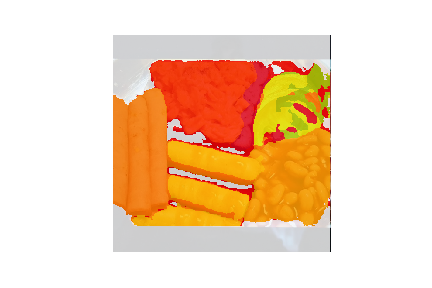

Cause exception while getting updates.
Traceback (most recent call last):
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/bot/api.py", line 139, in make_request
    async with session.post(url, data=req, **kwargs) as response:
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 1138, in __aenter__
    self._resp = await self._coro
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 559, in _request
    await resp.start(conn)
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client_reqrep.py", line 898, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/streams.py", line 616, in read
    await self._waiter
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/asyncio/futures.py", line 284, in __await__
    yield self  # This tells Task to wait for completion.
  File

In [81]:
i

In [69]:
import io

In [76]:
o = io.BytesIO()
i.save(o, format=i.format)
o = o.getvalue()

In [77]:
await m.reply_photo(o)

<Message {"message_id": 2441, "from": {"id": 5091011572, "is_bot": true, "first_name": "calorie_bot", "username": "food_classifier_bot"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658769360, "reply_to_message": {"message_id": 2438, "from": {"id": 78882798, "is_bot": false, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "language_code": "en"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658768961, "photo": [{"file_id": "AgACAgIAAxkBAAIJhmLezkE6uExbu6e-IDmI92c9eV7_AALAwDEb8n74ShMXBTVsclUgAQADAgADcwADKQQ", "file_unique_id": "AQADwMAxG_J--Ep4", "file_size": 1209, "width": 90, "height": 51}, {"file_id": "AgACAgIAAxkBAAIJhmLezkE6uExbu6e-IDmI92c9eV7_AALAwDEb8n74ShMXBTVsclUgAQADAgADbQADKQQ", "file_unique_id": "AQADwMAxG_J--Epy", "file_size": 16215, "width": 320, "height": 180}, {"file_id"

In [64]:
await m.reply_photo(i)

Task exception was never retrieved
future: <Task finished name='Task-119' coro=<Dispatcher._process_polling_updates() done, defined at /home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/dispatcher/dispatcher.py:407> exception=TypeError("Can not serialize value type: <class 'PIL.PngImagePlugin.PngImageFile'>\n headers: {}\n value: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=432x288 at 0x7FCDBC3F4AC0>")>
Traceback (most recent call last):
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/formdata.py", line 145, in _gen_form_data
    part = payload.get_payload(
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/payload.py", line 71, in get_payload
    return PAYLOAD_REGISTRY.get(data, *args, **kwargs)
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/payload.py", line 118, in get
    raise LookupError()
aiohttp.payload.LookupError

The above exception was the direct cause of the following exception

TypeError: Can not serialize value type: <class 'PIL.PngImagePlugin.PngImageFile'>
 headers: {}
 value: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=432x288 at 0x7FCDAC6FA4F0>

In [23]:
i = None
m = None

In [31]:
i

In [33]:
m

In [19]:
await bot.send_photo(message.from_user.id, img)

NameError: name 'message' is not defined

In [ ]:
await bot.send_photo(message.from_user.id, img)